In [1]:

import pandas as pd

%matplotlib inline

pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
%%time
from ams.config import constants
from pathlib import Path
from ams.services import file_services

senti_dataframes = []

folder_path_str = Path(constants.TWITTER_OUTPUT_RAW_PATH, "sent_drop", "main")

file_paths = file_services.list_files(folder_path_str, ends_with=".parquet", use_dir_recursion=True)

Setting up logging...
Will use logging path: C:\Users\Chris\workspaces\data\logs\alpha_media_signal
Wall time: 39 ms


In [3]:
from ams.utils.date_utils import TZ_AMERICA_NEW_YORK, STANDARD_DAY_FORMAT
import pytz

def convert_to_date_string(utc_timestamp: int):
    dt_utc = datetime.fromtimestamp(utc_timestamp)
    dt_nyc = dt_utc.astimezone(pytz.timezone(TZ_AMERICA_NEW_YORK))
    return dt_nyc.strftime(STANDARD_DAY_FORMAT)

In [4]:
%%time

from ams.utils import date_utils
from datetime import datetime

twitter_format = date_utils.TWITTER_LONG_FORMAT 
    
def add_ts(date_string: str):
        result = None
        try:
            dt = datetime.strptime(date_string, twitter_format)
            result = int(dt.timestamp())
        except Exception as e:
            pass
        return result

def add_timestamp(df):
    print(f'Count: {df.shape[0]}')
        
    df = df[df['created_at'].notnull()]
    
    df["created_at_timestamp"] = df["created_at"].apply(add_ts)
    
    return df

Wall time: 0 ns


In [5]:

def get_fave_cols(df):
    return df[["created_at",
                     "user_screen_name",
                     "favorite_count",
                     "in_reply_to_screen_name",
                     "user_verified",
                     "metadata_result_type",
                     "user_listed_count",
                     "user_time_zone",
                     "user_has_extended_profile",
                     "in_reply_to_status_id",
                     "user_statuses_count",
                     "user_protected",
                     "user_is_translation_enabled",
                     "user_location",
                     "lang",
                     "user_geo_enabled",
                     "place_country",
                     "place_name",
                     "possibly_sensitive",
                     "user_friends_count",
                     "retweet_count",
                     "user_follow_request_sent",
                     "user_followers_count",
                     "f22_ticker",
                     "f22_has_cashtag",
                     "f22_ticker_in_text",
                     "f22_num_other_tickers_in_tweet",
                     "f22_sentiment_pos",
                     "f22_sentiment_neu",
                     "f22_sentiment_neg",
                     "f22_sentiment_compound",
                     "f22_id"]]

In [6]:
from ams.services import  file_services
from pyspark.sql import DataFrame

tag = 'lpd'
parent_path = Path(constants.TWITTER_OUTPUT_RAW_PATH, 'learning_prep_drop', "main")
sent_drop_path = file_services.create_unique_folder_name(parent_path, prefix=tag)

print(f"Drop path: '{sent_drop_path}'.")

def persist_parquet(df: DataFrame):
    file_path =  file_services.create_unique_filename(parent_dir=sent_drop_path, prefix="lpd", extension="parquet")
    file_path_str = str(file_path)
    df.to_parquet(file_path_str)

Drop path: 'C:\Users\Chris\workspaces\data\twitter\learning_prep_drop\main\lpd_2021-01-07_13-57-04-913.81'.


In [7]:
%%time

def calc_compound_score(row):
    return row["user_followers_count"] * row["f22_sentiment_compound"]

samples = []
tot_files = len(file_paths)
for f_ndx, f in enumerate(file_paths):
    print(f"Processing {f_ndx + 1} of {tot_files}: {f}")
    df = pd.read_parquet(f)
    
    print(f"\t{df.shape}")
    
    df = get_fave_cols(df)
    
    df = add_timestamp(df)
       
    df = df[df['created_at_timestamp'].notnull()]
    
    df['date'] = df['created_at_timestamp'].apply(convert_to_date_string)
    
    df = df[df['user_followers_count'].notnull()]
    df = df[df['f22_sentiment_compound'].notnull()]
    
    df['user_followers_count'] = df['user_followers_count'].astype("int")
    df['f22_sentiment_compound'] = df['f22_sentiment_compound'].astype("float64")            
            
    df['f22_compound_score'] = df.apply(calc_compound_score, axis=1)
    
    df = df.drop_duplicates(subset=['f22_id'])
    
    persist_parquet(df=df)
    samples.append(df.sample(frac=.001))


Processing 1 of 188: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2021-01-07_12-51-43-61.32\part.0.parquet
	(3390, 79)
Count: 3390
Processing 2 of 188: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2021-01-07_12-51-43-61.32\part.1.parquet
	(3390, 79)
Count: 3390
Processing 3 of 188: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2021-01-07_12-51-43-61.32\part.10.parquet
	(3390, 79)
Count: 3390
Processing 4 of 188: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2021-01-07_12-51-43-61.32\part.11.parquet
	(3390, 79)
Count: 3390
Processing 5 of 188: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2021-01-07_12-51-43-61.32\part.12.parquet
	(3390, 79)
Count: 3390
Processing 6 of 188: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2021-01-07_12-51-43-61.32\part.13.parquet
	(3390, 79)
Count: 3390
Processing 7 of 188: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2021-01-07_12-51-43-61.32\part.14.parquet
	(3390, 79)
Count:

	(3390, 79)
Count: 3390
Processing 59 of 188: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2021-01-07_13-46-36-103.43\part.13.parquet
	(3390, 79)
Count: 3390
Processing 60 of 188: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2021-01-07_13-46-36-103.43\part.14.parquet
	(3390, 79)
Count: 3390
Processing 61 of 188: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2021-01-07_13-46-36-103.43\part.15.parquet
	(3390, 79)
Count: 3390
Processing 62 of 188: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2021-01-07_13-46-36-103.43\part.16.parquet
	(3390, 79)
Count: 3390
Processing 63 of 188: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2021-01-07_13-46-36-103.43\part.17.parquet
	(3390, 79)
Count: 3390
Processing 64 of 188: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2021-01-07_13-46-36-103.43\part.18.parquet
	(3390, 79)
Count: 3390
Processing 65 of 188: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2021-01-07_13-46-36-1

Count: 3390
Processing 116 of 188: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2021-01-07_13-47-45-393.76\part.16.parquet
	(3390, 79)
Count: 3390
Processing 117 of 188: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2021-01-07_13-47-45-393.76\part.17.parquet
	(3390, 79)
Count: 3390
Processing 118 of 188: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2021-01-07_13-47-45-393.76\part.18.parquet
	(3390, 79)
Count: 3390
Processing 119 of 188: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2021-01-07_13-47-45-393.76\part.19.parquet
	(3390, 79)
Count: 3390
Processing 120 of 188: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2021-01-07_13-47-45-393.76\part.2.parquet
	(3390, 79)
Count: 3390
Processing 121 of 188: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2021-01-07_13-47-45-393.76\part.20.parquet
	(3390, 79)
Count: 3390
Processing 122 of 188: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2021-01-07_13-47-45-393.76\

Count: 3390
Processing 172 of 188: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2021-01-07_13-48-55-148.99\part.18.parquet
	(3390, 79)
Count: 3390
Processing 173 of 188: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2021-01-07_13-48-55-148.99\part.19.parquet
	(3390, 79)
Count: 3390
Processing 174 of 188: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2021-01-07_13-48-55-148.99\part.2.parquet
	(3390, 79)
Count: 3390
Processing 175 of 188: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2021-01-07_13-48-55-148.99\part.20.parquet
	(3390, 79)
Count: 3390
Processing 176 of 188: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2021-01-07_13-48-55-148.99\part.21.parquet
	(3390, 79)
Count: 3390
Processing 177 of 188: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2021-01-07_13-48-55-148.99\part.22.parquet
	(3390, 79)
Count: 3390
Processing 178 of 188: C:\Users\Chris\workspaces\data\twitter\sent_drop\main\sd_2021-01-07_13-48-55-148.99\

Wall time: 278 ms


<AxesSubplot:xlabel='date'>

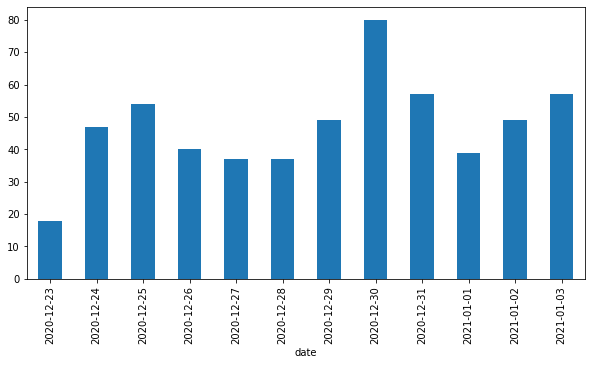

In [8]:
%%time 

df_combined = pd.concat(samples, axis=0)

df_combined.sort_values(by=['date'], inplace=True)

day_groups = df_combined.groupby(df_combined['date'])['date'].count()

day_groups.plot(kind='bar', figsize=(10,5), legend=None)